In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from deepinv.physics.blur import gaussian_blur
import torch

c:\Users\s2558406\Documents\Repos\ram-experiments\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# Parameters
grid_size_x = 30
grid_size_y = 53
kernel_size = 15
frames = 60  # number of frames in the animation
spacing = 0  # pixels between kernels
angle_min, angle_max = -90, 90  # sinusoidal angle limits (degrees)
sigma_x_max = 5.0
sigma_y_max = 5.0

# Canvas size
canvas_size = grid_size_x * (kernel_size + spacing), grid_size_y * (kernel_size + spacing)

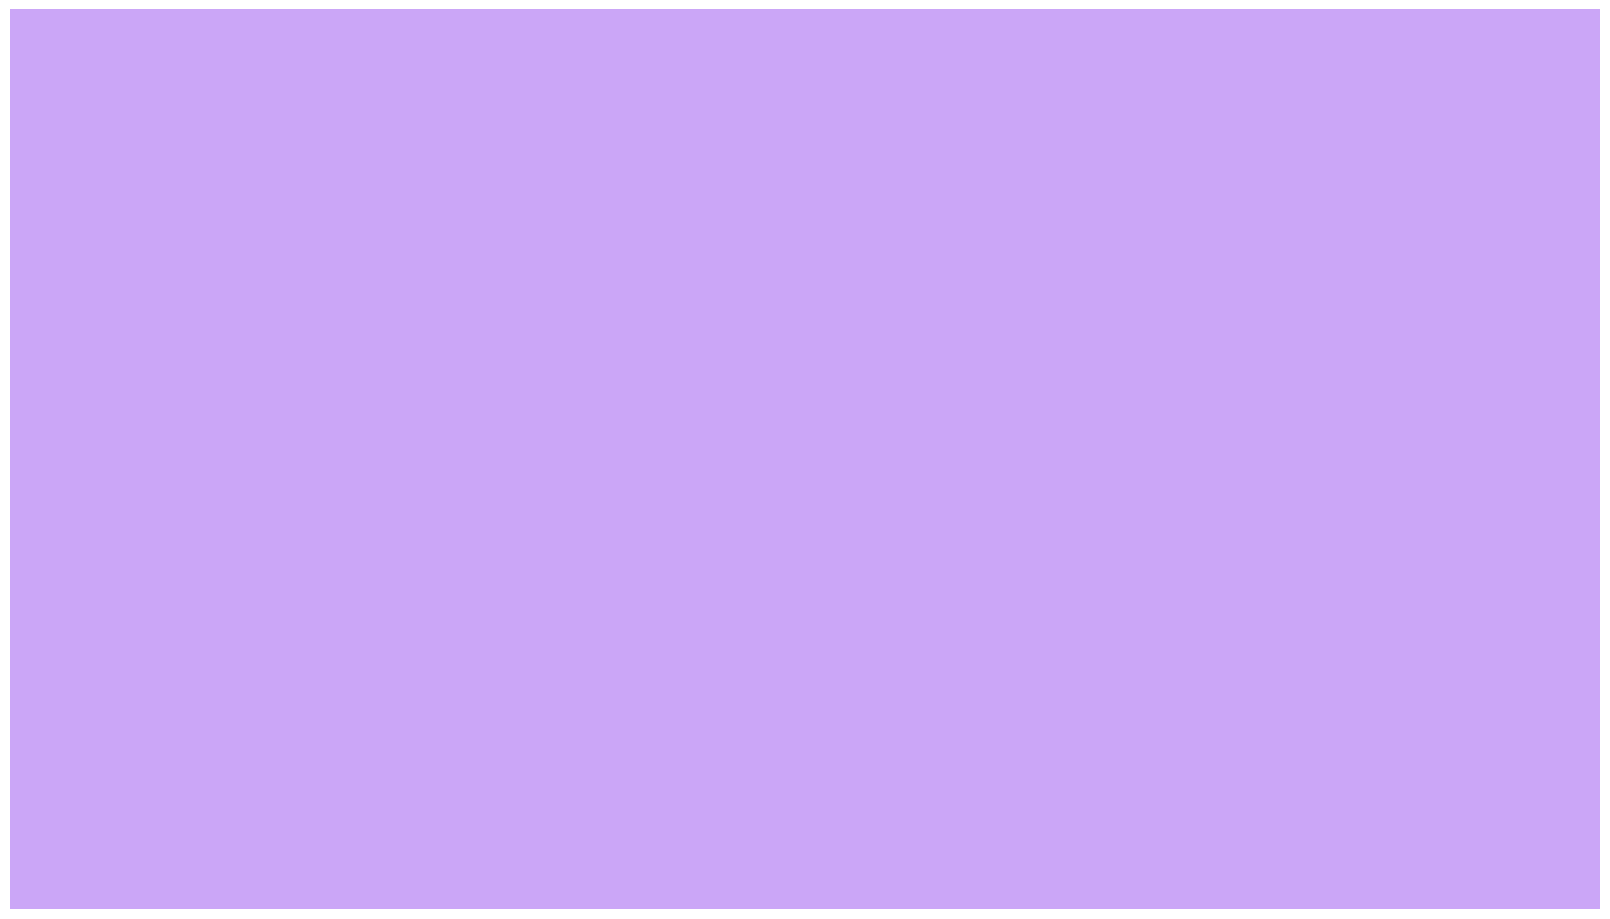

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create custom soft purple colormap (white to pastel purple)
purple_cmap = LinearSegmentedColormap.from_list(
    "soft_purple", ["#ffffff", "#cba6f7"]
)

# Setup figure with white background
fig, ax = plt.subplots(figsize=(16, 9), facecolor="white")
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.axis('off')               # Hide axis
ax.set_position([0, 0, 1, 1])  # Fill the entire figure
image = ax.imshow(np.ones(canvas_size), cmap=purple_cmap, vmin=0, vmax=1)

In [16]:
# Precompute sigma_x and sigma_y grids (faster drop at start using power curve)
x_vals = np.linspace(0, 1, grid_size_x)
y_vals = np.linspace(0, 1, grid_size_y)

gamma = 1.5  # >1 makes it drop faster near 0

x_scaled = (1 - x_vals) ** gamma
y_scaled = (1 - y_vals) ** gamma

sigma_x_grid = sigma_x_max * x_scaled
sigma_y_grid = sigma_y_max * y_scaled


In [17]:
def get_kernel(s_x, s_y, angle, kernel_size):
    blur_kernel = gaussian_blur(sigma=(s_x, s_y), angle=angle)[0, 0]  # shape (H, W)

    # Pad or crop to kernel_size
    kh, kw = blur_kernel.shape
    pad_h = max(0, kernel_size - kh)
    pad_w = max(0, kernel_size - kw)
    crop_h = max(0, kh - kernel_size)
    crop_w = max(0, kw - kernel_size)

    # Pad if needed
    if pad_h > 0 or pad_w > 0:
        blur_kernel = torch.nn.functional.pad(
            blur_kernel,
            (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2),
            mode='constant',
            value=0,
        )

    # Crop if needed
    if crop_h > 0 or crop_w > 0:
        start_h = crop_h // 2
        start_w = crop_w // 2
        blur_kernel = blur_kernel[start_h:start_h+kernel_size, start_w:start_w+kernel_size]

    kernel = blur_kernel.cpu().numpy()
    return kernel

In [24]:
# Animation update function
def plot(frame):
    angle_offset = (np.sin(2 * np.pi * frame / frames) + 1) / 2
    angle = angle_min + angle_offset * (angle_max - angle_min)

    canvas = np.zeros(canvas_size)

    for i in range(grid_size_x):
        for j in range(grid_size_y):
            s_x = sigma_x_grid[i]  # horizontal variation
            s_y = sigma_y_grid[j]  # vertical variation

            if s_x <= 0 and s_y <= 0:
                kernel = np.zeros((kernel_size, kernel_size))
                #kernel[kernel_size // 2, kernel_size // 2] = 1.0
            else:
                kernel = get_kernel(s_x, s_y, angle, kernel_size)
            
            kernel = np.nan_to_num(kernel)

            # Normalize kernel for visualization
            kernel = kernel / kernel.max() if kernel.max() != 0 else kernel

            x_start = i * (kernel_size + spacing)
            y_start = j * (kernel_size + spacing)
            canvas[x_start:x_start + kernel_size, y_start:y_start + kernel_size] = kernel
    
    return canvas

def update(frame):
    canvas = plot(frame)
    image.set_data(canvas)
    return [image]

# Create animation
ani = FuncAnimation(fig, update, frames=frames, blit=True)

In [22]:
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
ani.save("ram_website_bg.gif", fps=15, dpi=200)
# NOTE use giphy to compress

In [27]:
plot(0).shape

(450, 795)

In [29]:
450*795*60*256*3*8 / (1024)

128790000.0